In [1]:
%%bash
wget http://data.dmlc.ml/models/imagenet/vgg/vgg16-symbol.json
wget http://data.dmlc.ml/models/imagenet/vgg/vgg16-0000.params

--2017-08-04 22:00:32--  http://data.dmlc.ml/models/imagenet/vgg/vgg16-symbol.json
Resolving data.dmlc.ml... 54.208.175.7
Connecting to data.dmlc.ml|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16554 (16K) [application/json]
Saving to: ‘vgg16-symbol.json’

     0K .......... ......                                     100% 53.8K=0.3s

2017-08-04 22:00:33 (53.8 KB/s) - ‘vgg16-symbol.json’ saved [16554/16554]

--2017-08-04 22:00:33--  http://data.dmlc.ml/models/imagenet/vgg/vgg16-0000.params
Resolving data.dmlc.ml... 54.208.175.7
Connecting to data.dmlc.ml|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553431792 (528M)
Saving to: ‘vgg16-0000.params’

     0K .......... .......... .......... .......... ..........  0% 81.9K 1h49m
    50K .......... .......... .......... .......... ..........  0%  162K 82m48s
   100K .......... .......... .......... .......... ..........  0% 10.3M 55m29s
   150K .......... ......

In [2]:
%%bash
wget http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-symbol.json
wget http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-0000.params

--2017-08-04 22:16:39--  http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-symbol.json
Resolving data.dmlc.ml... 54.208.175.7
Connecting to data.dmlc.ml|54.208.175.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229097 (224K) [application/json]
Saving to: ‘resnet-152-symbol.json’

     0K .......... .......... .......... .......... .......... 22% 60.9K 3s
    50K .......... .......... .......... .......... .......... 44%  162K 1s
   100K .......... .......... .......... .......... .......... 67% 9.65M 1s
   150K .......... .......... .......... .......... .......... 89% 11.3M 0s
   200K .......... .......... ...                             100% 78.8K=1.4s

2017-08-04 22:16:42 (155 KB/s) - ‘resnet-152-symbol.json’ saved [229097/229097]

--2017-08-04 22:16:42--  http://data.dmlc.ml/models/imagenet/resnet/152-layers/resnet-152-0000.params
Resolving data.dmlc.ml... 54.208.175.7
Connecting to data.dmlc.ml|54.208.175.7|:80... connected.
HTTP request 

In [3]:
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2,sys,time
from collections import namedtuple
from matplotlib import pyplot as plt

In [4]:
def loadModel(modelname):
    t1 = time.time()
    sym, arg_params, aux_params = mx.model.load_checkpoint(modelname, 0)
    t2 = time.time()
    t = 1000*(t2-t1)
    print("Loaded in %2.2f milliseconds" % t)
    arg_params['prob_label'] = mx.nd.array([0])
    mod = mx.mod.Module(symbol=sym)
    mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
    mod.set_params(arg_params, aux_params)
    return mod

In [5]:
def loadCategories():
    synsetfile = open('synset.txt', 'r')
    synsets = []
    for l in synsetfile:
        synsets.append(l.rstrip())
    return synsets

In [6]:
def prepareNDArray(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224,))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return mx.nd.array(img)

In [7]:
def predict(filename, model, categories, n):
    array = prepareNDArray(filename)
    Batch = namedtuple('Batch', ['data'])
    t1 = time.time()
    model.forward(Batch([array]))
    t2 = time.time()
    t = 1000*(t2-t1)
    print("Predicted in %2.2f millsecond" % t)
    prob = model.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)
    sortedprobindex = np.argsort(prob)[::-1]
    topn = []
    for i in sortedprobindex[0:n]:
        topn.append((prob[i], categories[i]))
    return topn

In [8]:
def init(modelname):
    model = loadModel(modelname)
    cats = loadCategories()
    return model, cats

In [9]:
vgg16,c = init("vgg16")
resnet152,c = init("resnet-152")
inceptionv3,c = init("Inception-BN")

Loaded in 345.11 milliseconds
Loaded in 181.60 milliseconds


/Users/taemyung/anaconda/envs/py35/lib/python3.5/site-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
	prob_label
  warnings.warn(msg)
/Users/taemyung/anaconda/envs/py35/lib/python3.5/site-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


Loaded in 42.08 milliseconds


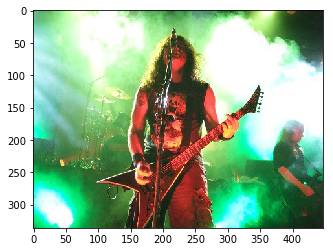

In [12]:
filename = "kreator.jpeg"
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [14]:
print("*** VGG16")
print(predict(filename,vgg16,c,5))

*** VGG16
Predicted in 0.19 millsecond
[(0.64369655, 'n03272010 electric guitar'), (0.25248611, 'n04296562 stage'), (0.012535729, 'n04141076 sax, saxophone'), (0.011808144, 'n04487394 trombone'), (0.0083501106, 'n02231487 walking stick, walkingstick, stick insect')]


In [15]:
print("*** ResNet-152")
print(predict(filename,resnet152,c,5))

*** ResNet-152
Predicted in 0.21 millsecond
[(0.90913397, 'n04296562 stage'), (0.044344787, 'n03272010 electric guitar'), (0.032163061, 'n03759954 microphone, mike'), (0.0091668647, 'n04286575 spotlight, spot'), (0.0016255474, 'n02676566 acoustic guitar')]


In [16]:
print("*** Inception v3")
print(predict(filename,inceptionv3,c,5))

*** Inception v3
Predicted in 0.14 millsecond
[(0.65444523, 'n03272010 electric guitar'), (0.22117805, 'n04296562 stage'), (0.076268889, 'n04456115 torch'), (0.016225286, 'n04286575 spotlight, spot'), (0.0081241438, 'n02676566 acoustic guitar')]
